# Setup


In [2]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from modules.wiki_parser import FileProcessor, WikiTextExtractor
from modules.nlp import NLP

DATA_DIR = Path().cwd() / "data"

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Article parsing


In [3]:
ARTICLE_DIR = DATA_DIR / "articles"

file_processor = FileProcessor()
wiki_text_extractor = WikiTextExtractor()

# Fetch all article file paths
file_paths = file_processor.fetch_file_paths(ARTICLE_DIR)

# Extract text from all articles
article_texts = [wiki_text_extractor.process_file(
    file_path) for file_path in tqdm(file_paths)]
articles_df = pd.concat(article_texts)
articles_df.index = pd.to_datetime(articles_df.index)

# Record which rows are Putin and Xi
# This is somewhat hacky and should be improved if we have time...
articles_df['file_path_string'] = articles_df['file_path'].apply(str)
articles_df['figure'] = np.where(
    articles_df['file_path_string'].str.contains('Putin'), 'Putin',
    np.where(articles_df['file_path_string'].str.contains('Xi'), 'Xi', None)
)

 34%|███▍      | 689/2000 [00:10<00:17, 73.81it/s]

Error processing /Users/felixwallis/Desktop/Oxford MSc/Oxford Social Data Science Course/Fundamentals for Social Data Science in Python/sds-week-2-wikipedia-presentation/data/articles/Vladimir_Putin/2023/05/1155008451.xml: too many values to unpack (expected 2)
Error processing /Users/felixwallis/Desktop/Oxford MSc/Oxford Social Data Science Course/Fundamentals for Social Data Science in Python/sds-week-2-wikipedia-presentation/data/articles/Vladimir_Putin/2023/05/1155008376.xml: too many values to unpack (expected 2)


 51%|█████     | 1017/2000 [00:15<00:13, 72.28it/s]

Error processing /Users/felixwallis/Desktop/Oxford MSc/Oxford Social Data Science Course/Fundamentals for Social Data Science in Python/sds-week-2-wikipedia-presentation/data/articles/Xi_Jinping/2022/11/1124670506.xml: too many values to unpack (expected 2)


 79%|███████▊  | 1571/2000 [00:21<00:04, 94.77it/s]

Error processing /Users/felixwallis/Desktop/Oxford MSc/Oxford Social Data Science Course/Fundamentals for Social Data Science in Python/sds-week-2-wikipedia-presentation/data/articles/Xi_Jinping/2024/08/1242366887.xml: too many values to unpack (expected 2)


100%|██████████| 2000/2000 [00:26<00:00, 75.33it/s]


# Embeddings


In [4]:
word_vectors = KeyedVectors.load_word2vec_format(
    DATA_DIR / "glove.840B.300d.txt", binary=False, no_header=True)

## Generating word embeddings


In [24]:
nlp = NLP()

# Tokenize text and remove stop words
tqdm.pandas(desc="Tokenizing article text")
articles_df['tokens'] = articles_df['section_text'].progress_apply(
    nlp.tokenize_text)

# Generate word embeddings
articles_df['weighted_embeddings'] = nlp.generate_tfidf_weighted_embeddings(
    articles_df['tokens'], word_vectors)

Generating weighted embeddings: 100%|██████████| 98832/98832 [01:56<00:00, 849.02it/s]


## Calculating pairwise cosine similarities


In [41]:
def calculate_monthly_similarities(group: pd.DataFrame, figure_1: str,
                                   figure_2: str, embeddings_column: str):
    """
    Calculate the cosine similarity between the monthly average embeddings of two figures.
    """
    # Filter for each figure
    figure_1_data = group[group['figure'] == figure_1]
    figure_2_data = group[group['figure'] == figure_2]

    # Skip if either figure is missing in this month
    if figure_1_data.empty or figure_2_data.empty:
        return np.nan

    # Use stack_embeddings to create matrices
    figure_1_embeddings = np.vstack(figure_1_data[embeddings_column])
    figure_2_embeddings = np.vstack(figure_2_data[embeddings_column])

    # Calculate similarity
    similarity_matrix = cosine_similarity(
        figure_1_embeddings, figure_2_embeddings)
    average_similarity = np.mean(similarity_matrix)

    return average_similarity


articles_df['year_month'] = articles_df.index.to_period('M')

# Calculate similarities
article_monthly_similarities = articles_df.groupby('year_month').apply(
    calculate_monthly_similarities, 'Putin', 'Xi', 'weighted_embeddings')

/var/folders/g4/5xzy77v17m1fbt0xq_sn3f140000gn/T/ipykernel_82021/1526775849.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  articles_df['year_month'] = articles_df.index.to_period('M')
/var/folders/g4/5xzy77v17m1fbt0xq_sn3f140000gn/T/ipykernel_82021/1526775849.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  article_monthly_similarities = articles_df.groupby('year_month').apply(


## Plotting cosine similarities


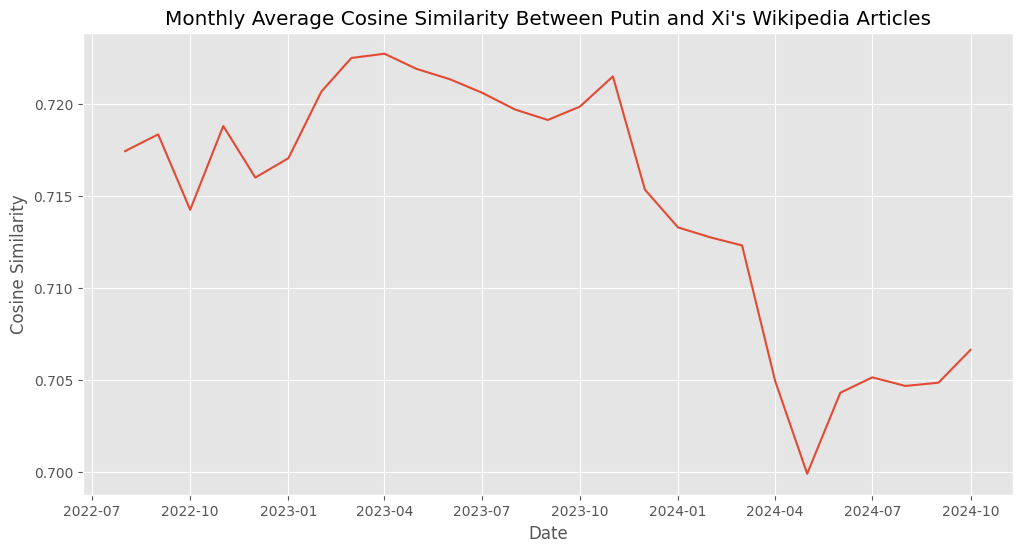

In [49]:
plt.figure(figsize=(12, 6))

plt.plot(article_monthly_similarities.index.to_timestamp(),
         article_monthly_similarities)
plt.title(
    "Monthly Average Cosine Similarity Between Putin and Xi's Wikipedia Articles")
plt.xlabel("Date")
plt.ylabel("Cosine Similarity")
plt.show()

# Counting the number of revisions over time
